In [1]:
suppressPackageStartupMessages({
    library(HGNChelper)
    library(stringr)
    library(tidyverse)
    library(limma)
    library(GSVA)
    library(edgeR)
    library(ggsignif)
    library(survival)
    library(ROCR)
})

Warning message:
“package ‘limma’ was built under R version 4.1.3”
Warning message:
“package ‘edgeR’ was built under R version 4.1.3”


In [2]:
normals <- c(
    "BRCA" = "BREAST",
    "COAD" = "COLON",
    "READ" = "COLON",
    "ESCA" = "ESOPHAGUS",
    "LIHC" = "LIVER",
    "LUAD" = "LUNG",
    "PAAD" = "PANCREAS",
    "PRAD" = "PROSTATE",
    "STAD" = "STOMACH"
)
presigs <- c(
    'STAD' = 'M5',
    'BRCA' = 'M4',
    'CRC' = 'M9',
    'EAC' = 'M1',
    'LIHC' = 'M2',
    'LUAD' = 'M1',
    'PDAC' = 'M4',
    'PRAD' = 'M6'
)
cancer_types <- names(normals)

In [6]:
cancer <- "STAD"
dt.tcga <- get(load(paste0(cancer, ".RData")))
dt.gtex <- get(load(paste0(normals[cancer], ".RData")))

cancer.alias <- "STAD"
sigs <- read.table(paste0("/data/egc21/data_db/6.signature.v1.6.median/", cancer.alias, ".txt"), header = T)[[presigs[[cancer.alias]]]]

In [7]:
metadata <- dt.tcga@colData
keywords <- c("type", "patho", "histo", "molecu", "sub")
nn <- names(dt.tcga@colData)[grepl(paste(keywords, collapse = "|"), names(dt.tcga@colData))]
tt <- lapply(nn, function(x) {
    tmp <- table(dt.tcga@colData[[x]])
    if(length(tmp) < 30 & length(tmp) > 1) {tmp} else{NA}
})
names(tt) <- nn
tt <- tt[!is.na(tt)]
tt

$tcga.cgc_sample_sample_type

      Primary Tumor Solid Tissue Normal 
                415                  37 

$tcga.gdc_cases.samples.sample_type_id

  1  11 
416  37 

$tcga.gdc_cases.samples.sample_type

      Primary Tumor Solid Tissue Normal 
                416                  37 

$tcga.cgc_sample_sample_type_code

  1  11 
415  37 

$tcga.cgc_case_pathologic_n

 N0  N1  N2  N3 N3a N3b  NX 
137 125  91  29  46   7  17 

$tcga.cgc_case_histological_diagnosis

                            Stomach  Adenocarcinoma  Diffuse Type 
                                                               75 
           Stomach  Adenocarcinoma  Not Otherwise Specified (NOS) 
                                                              171 
Stomach  Intestinal Adenocarcinoma  Not Otherwise Specified (NOS) 
                                                               82 
                 Stomach  Intestinal Adenocarcinoma  Tubular Type 
                                                          

In [8]:
tcgagtexCnt <- cbind(dt.tcga[, dt.tcga$tcga.gdc_cases.samples.sample_type %in% c("Primary Tumor", "Solid Tissue Normal")]@assays@data$raw_counts[,],
     dt.gtex@assays@data$raw_counts[,])
tgDGE = DGEList(tcgagtexCnt)
sampleTCGA <- intersect(rownames(tgDGE$samples), colnames(dt.tcga))
tgDGE$samples$group <- "Normal"
TCGASampleType <- c("Primary Tumor" = "Tumor", "Solid Tissue Normal" = "Adjecent")
tgDGE$samples[sampleTCGA,]$group <- TCGASampleType[dt.tcga@colData[sampleTCGA, 'tcga.cgc_sample_sample_type']]

In [9]:
tcgagtexCnt <- cbind(dt.tcga[, dt.tcga$tcga.gdc_cases.samples.sample_type %in% c("Primary Tumor", "Solid Tissue Normal")]@assays@data$raw_counts[,],
     dt.gtex@assays@data$raw_counts[,])
tgDGE = DGEList(tcgagtexCnt)
sampleTCGA <- intersect(rownames(tgDGE$samples), colnames(dt.tcga))
tgDGE$samples$group <- "Normal"
TCGASampleType <- c("Primary Tumor" = "Tumor", "Solid Tissue Normal" = "Adjecent")
tgDGE$samples[sampleTCGA,]$group <- TCGASampleType[dt.tcga@colData[sampleTCGA, 'tcga.gdc_cases.samples.sample_type']]

duplicated.gene <- table(dt.tcga@rowRanges$gene_name) %>% .[.>1] %>% names
RKPM <- tgDGE$counts / dt.tcga@rowRanges[rownames(tgDGE$counts),]$bp_length
TPM <- t(t(RKPM)*1e6/colSums(RKPM))
head(TPM[,1:6])

TPM.gene_name <- data.frame(TPM)
colnames(TPM.gene_name) <- colnames(TPM)
TPM.gene_name <- TPM.gene_name %>% rownames_to_column("gene_id") %>% inner_join(data.frame(dt.gtex@rowRanges) %>% select(gene_id, gene_name))
TPM.gene_name.1 <- TPM.gene_name %>% filter(!gene_name %in% duplicated.gene)
TPM.gene_name.2 <- TPM.gene_name %>% filter(gene_name %in% duplicated.gene) %>%
    group_by(gene_name) %>%
    summarise(across(where(is.numeric), sum))
TPM.gene_name.final <- bind_rows(TPM.gene_name.1, TPM.gene_name.2)
rownames(TPM.gene_name.final) <- TPM.gene_name.final$gene_name
TPM.gene_name.final <- TPM.gene_name.final %>% select(-c("gene_name", "gene_id"))
head(TPM.gene_name.final[1:6])

ssgsea.results <- gsva(as.matrix(TPM.gene_name.final), data.frame(sigs), method = "ssgsea", ssgsea.norm = T)

ssgsea.data <- data.frame(t(ssgsea.results))
ssgsea.data$group <- factor(tgDGE$samples[rownames(ssgsea.data),]$group, levels = c("Normal", "Adjecent", "Tumor"))
table(ssgsea.data$group)
ssgsea.data <- ssgsea.data %>%
#     filter(group != "Adjecent") %>%
    mutate(score = as.numeric(scale(sigs)))
head(ssgsea.data)

,59ed0c45-930c-4fc2-a09c-84d4c2005505,f1bf1bc7-1fb8-4881-9a48-cb8efbe99e09,ff94f98a-8a7d-4bba-b086-736442ed9a11,3f7cb9ca-7faa-41d0-9558-000fde573811,06559d18-e45e-4697-bcdb-c781bcf71327,d65dad9a-b276-417f-a169-c9491402e42b
ENSG00000278704.1,0,0,0,0,0,0
ENSG00000277400.1,0,0,0,0,0,0
ENSG00000274847.1,0,0,0,0,0,0
ENSG00000277428.1,0,0,0,0,0,0
ENSG00000276256.1,0,0,0,0,0,0
ENSG00000278198.1,0,0,0,0,0,0


Joining, by = "gene_id"


,59ed0c45-930c-4fc2-a09c-84d4c2005505,f1bf1bc7-1fb8-4881-9a48-cb8efbe99e09,ff94f98a-8a7d-4bba-b086-736442ed9a11,3f7cb9ca-7faa-41d0-9558-000fde573811,06559d18-e45e-4697-bcdb-c781bcf71327,d65dad9a-b276-417f-a169-c9491402e42b
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BX004987.1,0,0,0,0,0,0
AC145212.2,0,0,0,0,0,0
AC145212.1,0,0,0,0,0,0
AC011043.1,0,0,0,0,0,0
AC011043.2,0,0,0,0,0,0
AC011841.1,0,0,0,0,0,0


Warning message in .filterFeatures(expr, method):
“541 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 1 gene sets.
  |======================================================================| 100%




  Normal Adjecent    Tumor 
     384       37      416 

,sigs,group,score
,<dbl>,<fct>,<dbl>
59ed0c45-930c-4fc2-a09c-84d4c2005505,1.921447,Tumor,0.9156697
f1bf1bc7-1fb8-4881-9a48-cb8efbe99e09,1.933722,Adjecent,0.9699552
ff94f98a-8a7d-4bba-b086-736442ed9a11,1.934011,Tumor,0.9712362
3f7cb9ca-7faa-41d0-9558-000fde573811,1.811473,Tumor,0.4292909
06559d18-e45e-4697-bcdb-c781bcf71327,1.961767,Tumor,1.0939895
d65dad9a-b276-417f-a169-c9491402e42b,1.965114,Tumor,1.1087910


In [10]:
ssgsea.data.tumor <- ssgsea.data %>% filter(group == "Tumor") %>%
    rownames_to_column("external_id") %>%
    inner_join(dt.tcga@colData %>% data.frame %>% mutate(across(!is.character, as.character)), by = "external_id")
keywords <- c("tcga.cgc_case_histological_diagnosis", "tcga.cgc_case_pathologic_stage", "tcga.xml_histological_type", "tcga.xml_anatomic_neoplasm_subdivision", "tcga.xml_stage_event_pathologic_stage", "tcga.xml_reflux_history", "tcga.xml_family_history_of_stomach_cancer")

Warning message:
“Predicate functions must be wrapped in `where()`.

  # Bad
  data %>% select(is.character)

  # Good
  data %>% select(where(is.character))

ℹ Please update your code.
This message is displayed once per session.”


Warning message:
“Removed 426 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 426 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 58 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 58 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 56 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 56 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 58 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 58 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 58 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 58 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 34 rows containing

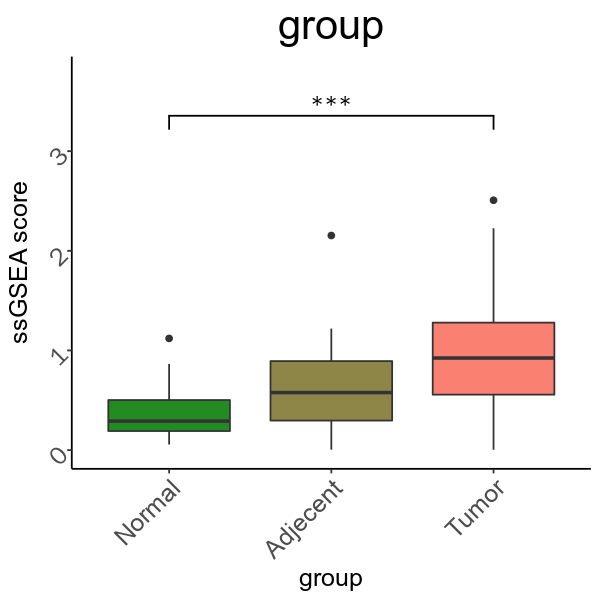

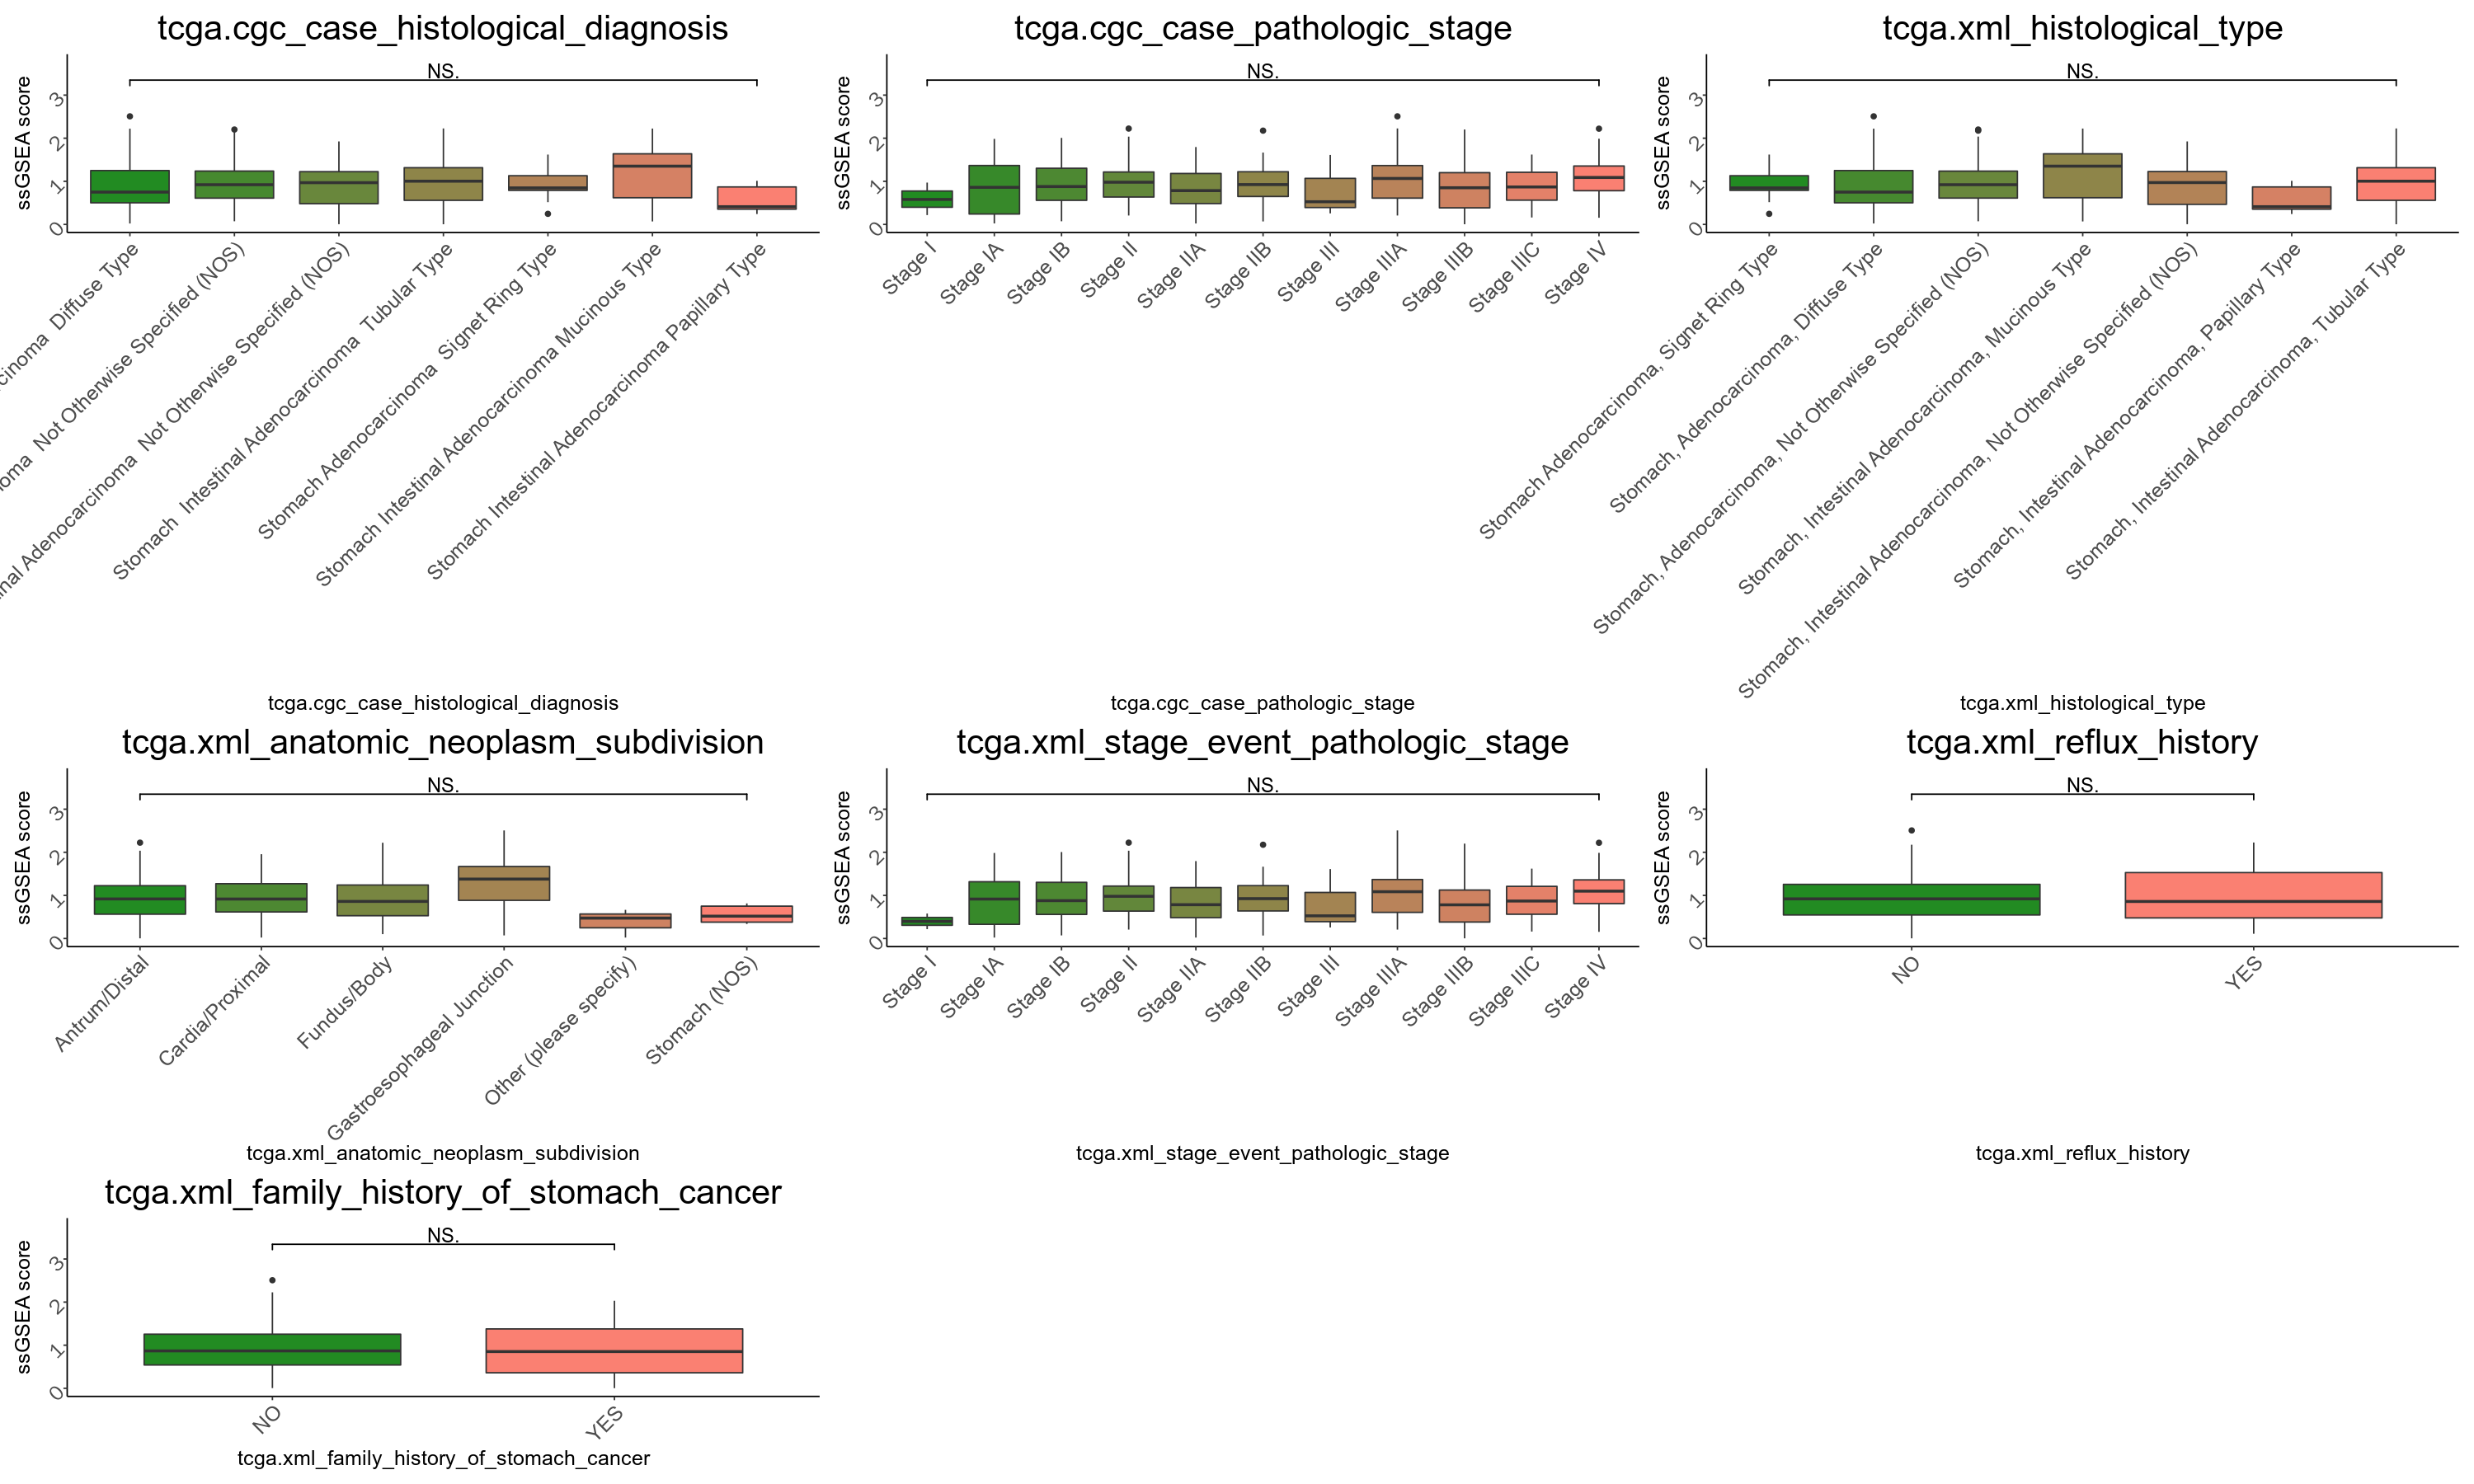

In [11]:
my_boxplot <- function(dt, value, gg){
    dt <- dt[!is.na(dt[[gg]]),]
    groups <- sort(unique(dt[[gg]]))
    mm = max(dt[[value]])
    nn = length(groups)
    ggplot(dt, aes(x = .data[[gg]], y = .data[[value]])) +
        geom_boxplot(aes(fill = .data[[gg]])) +
        scale_fill_manual(values = colorRampPalette(c("#228B22", "#FA8072"))(nn)) +
        labs(y = "ssGSEA score", title = gg) +
        geom_signif(
            comparisons = list(c(groups[length(groups)], groups[1])),
            test = wilcox.test,
            test.args = list(
                alternative = "two.sided",
                var.equal = FALSE,
                paired=FALSE),
            map_signif_level = T,
            textsize = 5,
            y_position = mm*1.25) +
        theme(
            panel.background = element_blank(),
            axis.line = element_line()) +
        theme(plot.title = element_text(hjust = 0.5, size = 25)) +
        theme(axis.text = element_text(size = 15, angle = 45, hjust = 1), axis.title = element_text(size = 15)) +
        scale_y_continuous(limits = c(0, mm*1.5)) +
        theme(legend.position = 'none') +
        NULL
}
options(repr.plot.height = 5, repr.plot.width = 5)
my_boxplot(ssgsea.data, "score", "group")
options(repr.plot.height = 15, repr.plot.width = 25)
patchwork::wrap_plots(lapply(keywords, function(x) {my_boxplot(ssgsea.data.tumor, "score", x)}))

In [ ]:

options(repr.plot.height = 5, repr.plot.width = 5)
# Step-17
x = calcNormFactors(tgDGE, method = "upperquartile")
head(x$samples$norm.factors)
group <- x$samples$group


# Step-18
design = model.matrix(~0 + group)


# Step-19
colnames(design) = gsub("group", "", colnames(design))
contr.matrix = makeContrasts(TCGAvsGTEX = Tumor - Normal,
    levels = colnames(design))


# Step-20
v = voom(x, design, plot = T)


# Step-21
vfit = lmFit(v, design)
vfit = contrasts.fit(vfit, contrasts = contr.matrix)


# Step-22
efit = eBayes(vfit)
plotSA(efit, main = "Final model: Mean-variance trend")

# Step-23
summary(decideTests(efit))
tfit = treat(vfit, lfc = 0.58)
summary(decideTests(tfit))


# Step-24
DEGsTreat = topTreat(tfit, n = Inf)

[1] 0.7295242 0.9038643 1.2739155 0.8918141 1.2952374 1.1404162

In [ ]:
DEGsTreat$gene_name <- dt.tcga@rowRanges[rownames(DEGsTreat), ]$gene_name
# DEGsTreat %>%
#     filter(abs(logFC) > 1.5, adj.P.Val < 0.05) %>%
#     filter(gene_name %in% sigs) %>%
#     filter(!duplicated(gene_name)) %>%
#     identity
head(DEGsTreat)

options(repr.plot.height = 15, repr.plot.width = 15)
DEGsTreat %>% mutate(ingroup = gene_name %in% sigs) %>%
ggplot(aes(x = logFC, y = -log10(adj.P.Val))) +
    geom_point(aes(color = ingroup)) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = 0, linetype = "dashed") +
    scale_color_manual(values = c("grey", "red")) +
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "log2 fold change", y = "-log10(p-value)")

In [ ]:
survival_data <- ssgsea.data.tumor %>% transmute(
    time = as.numeric(ifelse(
        tcga.cgc_case_vital_status == "Dead",
        tcga.cgc_case_days_to_death,
        tcga.cgc_case_days_to_last_follow_up)) / 30,
    deceased = tcga.cgc_case_vital_status == "Dead",
    sample_id = external_id,
    enrich_score = sigs,
    enrich_score_z = score
) %>%
    na.omit %>%
    mutate(score_group = 1*(enrich_score >= median(enrich_score)))

survival_data$expr <- colMeans(TPM.gene_name.final[intersect(rownames(TPM.gene_name.final), sigs), survival_data$sample_id])

survival_data$expr_group <- 1*(survival_data$expr >= median(survival_data$expr))

In [ ]:

attach(survival_data)
m <- Surv(time, deceased)
summary(coxph(m ~ score_group, data = survival_data))

logt <- survdiff(m~score_group,data = survival_data)
p.val <- 1 - pchisq(logt$chisq, length(logt$n) - 1)
p.val <- format(p.val,digits=3)
p.val_os <- p.val
        
coxmodel <- coxph(m~score_group,data = survival_data)
fit <- summary(coxmodel)
HR <- fit$conf.int[1];
HR_os <- as.numeric(format(HR,digits=3))
low95_os <- fit$conf.int[3]; low95_os<- format(low95_os,digits=3)
up95_os <- fit$conf.int[4]; up95_os<- format(up95_os,digits=3)

kme <- survfit(formula = m ~ score_group, data = survival_data)

options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,5,5,2))
plot(kme,lty = c('solid','solid'),col=c('black','blue'),lwd = c(5,5),cex.axis = 2,cex.lab = 3.5,cex.main=3,
     xaxs='i',yaxs="i",xaxt = "n",yaxt="n",mark.time = T)

axis(side = 1,
     at = c(0,100,200,300,400),
     labels = c(0,100,200,300, 400),
                   tick = 0.1,
     cex.axis=2)

axis(side = 2,
     at = c(0,.2,.4,.6,.8,1),
     labels = c(0,0.2,0.4,0.6,0.8,1),
     tick = 0.1,
     cex.axis=2)
title(ylab="Disease-specific survival", mgp=c(3,1,0), cex.lab=2.2)
title(xlab="Time (months)", mgp=c(3,1,0), cex.lab=2.2)
legend('topright',c(paste('Low risk (',length(which(score_group==0))," patients",')',sep = ""),paste('High risk (',length(which(score_group==1))," patients",')',sep = "")),lty = c('solid','solid'),col=c('black','blue'),cex = 2,lwd = c(2,2))
text(250,0.6,paste("p = ",p.val_os, "\nHR ",HR_os," (",low95_os,"-",up95_os,")",sep = ""),cex = 2)
detach(survival_data)

In [ ]:

attach(survival_data)
m <- Surv(time, deceased)
summary(coxph(m ~ expr_group, data = survival_data))

logt <- survdiff(m~expr_group,data = survival_data)
p.val <- 1 - pchisq(logt$chisq, length(logt$n) - 1)
p.val <- format(p.val,digits=3)
p.val_os <- p.val
        
coxmodel <- coxph(m~expr_group,data = survival_data)
fit <- summary(coxmodel)
HR <- fit$conf.int[1];
HR_os <- as.numeric(format(HR,digits=3))
low95_os <- fit$conf.int[3]; low95_os<- format(low95_os,digits=3)
up95_os <- fit$conf.int[4]; up95_os<- format(up95_os,digits=3)

kme <- survfit(formula = m ~ expr_group, data = survival_data)

options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,5,5,2))
plot(kme,lty = c('solid','solid'),col=c('black','blue'),lwd = c(5,5),cex.axis = 2,cex.lab = 3.5,cex.main=3,
     xaxs='i',yaxs="i",xaxt = "n",yaxt="n",mark.time = T)

axis(side = 1,
     at = c(0,100,200,300,400),
     labels = c(0,100,200,300, 400),
                   tick = 0.1,
     cex.axis=2)

axis(side = 2,
     at = c(0,.2,.4,.6,.8,1),
     labels = c(0,0.2,0.4,0.6,0.8,1),
     tick = 0.1,
     cex.axis=2)
title(ylab="Disease-specific survival", mgp=c(3,1,0), cex.lab=2.2)
title(xlab="Time (months)", mgp=c(3,1,0), cex.lab=2.2)
legend('topright',c(paste('Low risk (',length(which(expr_group==0))," patients",')',sep = ""),paste('High risk (',length(which(expr_group==1))," patients",')',sep = "")),lty = c('solid','solid'),col=c('black','blue'),cex = 2,lwd = c(2,2))
text(250,0.6,paste("p = ",p.val_os, "\nHR ",HR_os," (",low95_os,"-",up95_os,")",sep = ""),cex = 2)
detach(survival_data)